# Quantum Mechanics Simulator - QHO
Reminder: Python `Complex` type has built in functions like `Complex.conjugate()`.
Ex: `(1+3j).conjugate()`

Class Hierarchy:
* `Operator`: Define an operation, comes with preset operations
* `State` Base Class:
* `Eigenstate`:

In [1]:
## --- import statements --- ##
import numpy as np
import matplotlib.pyplot as plt
import types

In [2]:
class Operator:
    '''Basically a list of functions to do, in order from left to right'''
    hbar = 1
    def Identity(  ):
        return Operator( lambda a_state : State(lambda x : a_state.x_rep_func(x),a_state[0]) )
    def Position(  ):
        return Operator( lambda a_state : State(lambda x : x*a_state.x_rep_func(x),a_state[0]) )
    def Momentum(  ):
        return Operator( lambda a_state : State(lambda x : -1j* (Operator.hbar) * np.gradient( a_state.x_rep_func(x), x),a_state[0]) )
    def Momentum2(  ):
        return Operator.Momentum()**2 
    
    def __init__(self, f,verbose=False):
        '''Give an operation to eventually perform on a state'''
        # https://stackoverflow.com/a/6528148
        self.operate = types.FunctionType(f.__code__, f.__globals__, f.__name__,
                                          f.__defaults__, f.__closure__)
        self.mat = None
        self.x_used_for_mat = None
        self.gen_basis = lambda n,a : (lambda x,m=n: np.exp(2j* m *np.pi*x/a)/(a)**0.5 )
        self.verbose = verbose
    
    def debug(self, *args):
        if self.verbose:
            print("DEBUG:", args)
            
    def to_mat(self,x=None,N=500,diag=False, ret=False):
        '''Produces the matrix equivalent of this operator, in the basis of cos(nx)
        If diag is True, it will attempt to also diagonalize this matrix.'''
        self.debug('Making matrix: ', (2*N+1,2*N+1))
        if x is None and self.x_used_for_mat is None:
                raise ValueError('You must provide an x array to use to calculate the matrix over')
        a = x[-1]-x[0]
        self.mat = np.zeros((2*N+1,2*N+1),dtype=complex)
        self.x_used_for_mat = np.copy(x)
        
        op_basisState = np.zeros(2*N+1,dtype=State)
        basisState    = np.zeros(2*N+1,dtype=State)
        for i in range(-N,N+1):
            op_basisState[i+N] = self*State( self.gen_basis(i,a),x )
            basisState[i+N]    =      State( self.gen_basis(i,a),x )  
        self.debug('Basis States Made')
        self.mat = np.array(np.outer(basisState,op_basisState),dtype=complex) #vectorize this to make it faster
        self.debug('Matrix is ', np.shape(self.mat))
        if ret:
            return np.copy(self.mat)
    
    def find_eig(self,x=None,N=500,retStates=False):
        '''Find eigenvals and eigenvectors. The larger N is, the more accurate results will be.'''
        if self.mat is None:
            self.to_mat(x=x,N=N)
        elif np.shape(self.mat) != (2*N+1,2*N+1):
            self.to_mat(x=x,N=N)
        eig_vals,eig_vecs = np.linalg.eig(self.mat)
        if retStates:
            eig_states = []
            for vec in eig_vecs:
                eig_states.append( sum([ State() ]))
                
        return eig_vals,eig_vecs

    def __mul__(self, nxtobj):
        '''Define how multiplication works on another object'''
        if isinstance(nxtobj, Operator):
            return Operator( lambda a_state : self.operate(nxtobj.operate(a_state)) )
        elif isinstance(nxtobj, int) or isinstance(nxtobj, float) or isinstance(nxtobj, complex):
            return Operator( lambda a_state : nxtobj*self.operate(a_state) )
        elif isinstance(nxtobj, State):
            return self.operate( nxtobj )
        else:
            raise ValueError
    def __rmul__(self, prevobj):
        if isinstance(prevobj, int) or isinstance(prevobj, float) or isinstance(prevobj, complex):
            return Operator( lambda a_state : prevobj*self.operate(a_state) )
        elif isinstance(prevobj, State):
            raise ValueError('Be more careful with parentheses!')
    def __add__(self,nxtobj):
        '''Define how multiplication works on another object'''
        if isinstance(nxtobj, Operator):
            return Operator( lambda a_state : self.operate(a_state) + nxtobj.operate(a_state) )
        elif isinstance(nxtobj, int) or isinstance(nxtobj, float) or isinstance(nxtobj, complex):
            return Operator( lambda a_state : nxtobj*Operator.Identity(a_state) + self.operate(a_state) )
        else:
            raise ValueError
    def __sub__(self,nxtobj):
        return self + (-1)*nxtobj
    def __pow__(self,n):
        n = int(n)
        op = Operator.Identity()
        for i in range(n):
            op *= self
        return op

In [3]:
class State:
    def __init__(self, f, x):
        self.x_rep_func = types.FunctionType(f.__code__, f.__globals__, f.__name__,
                                             f.__defaults__, f.__closure__)
        self.x_arr = np.copy(x)
    
    def conjugate(self):
        return State( lambda x : np.conj(self.x_rep_func(x)), self.x_arr )
        
    def norm(self):
        '''Normalize this state'''
        amplitude = (self*self)**0.5
        f = self.x_rep_func
        self.x_rep_func = lambda x : (1/amplitude)*types.FunctionType(f.__code__, f.__globals__, f.__name__,
                                      f.__defaults__, f.__closure__)(x)
        return self
    
    def plot(self, ax=None,labelR='Real Part',labelI='Imaginary Part',subplots=False):
        '''Plot the real and imaginary parts of this state'''
        if ax is None:
            ax = plt.gca()
        y = self.x_rep_func(self.x_arr)
        pR = ax.plot(self.x_arr,  np.real(y), label=labelR)
        pI = ax.plot(self.x_arr,  np.imag(y), label=labelI)
        ax.legend()
        return pR,pI
    
    def __mul__(self, nxtobj):
        '''Define A|a_state> and <b_state|a_state>'''
        if isinstance(nxtobj, int) or isinstance(nxtobj, float) or isinstance(nxtobj, complex):
            return State( lambda x : nxtobj*self.x_rep_func(x), self.x_arr )
        elif isinstance(nxtobj, State):
            if np.shape(self[0])!=np.shape(nxtobj[0]) or self[0][0]!=nxtobj[0][0] or self[0][-1]!=nxtobj[0][-1]:
                raise ValueError
            return np.trapz(self.conjugate()[1] * nxtobj[1],self.x_arr) #integrate (psi*)(psi)
        else:
            raise ValueError
    def __rmul__(self, prevobj):
        if isinstance(prevobj, int) or isinstance(prevobj, float) or isinstance(prevobj, complex):
            return State( lambda x : prevobj*self.x_rep_func(x), self.x_arr )
    def __add__(self, nxtobj):
        if isinstance(nxtobj, State):
            return State( lambda x : self.x_rep_func(x)+nxtobj.x_rep_func(x), self.x_arr)
        else:
            raise ValueError
    def __getitem__(self,i):
        '''Returns copies of numpy arrays stored in this state
        [0] returns x_arr
        [1] returns wavefunction psi(x)'''
        if i == 0:
            return np.copy( self.x_arr )
        elif i == 1:
            return self.x_rep_func( self.x_arr )
        else: 
            raise ValueError

### Testing with the Quantum Harmonic Oscillator,
Hamiltonian
![Logo](https://wikimedia.org/api/rest_v1/media/math/render/svg/0b8b0c21e1de998f920a5d164d82af426bbd99c5)
and exact Eigenenergies
![Logo](https://wikimedia.org/api/rest_v1/media/math/render/svg/ab89cf43fbca42581b3828be5e27315468c9689f)
Setting `hbar=omega=m=1`

Time to plot Ground State: 0.02299213409423828

DEBUG: ('Making matrix: ', (101, 101))
DEBUG: ('Basis States Made',)
DEBUG: ('Matrix is ', (101, 101))
Time to calculate Energy Eigenvals with 101 basis states: 4.154657602310181

DEBUG: ('Making matrix: ', (201, 201))
DEBUG: ('Basis States Made',)
DEBUG: ('Matrix is ', (201, 201))
Time to calculate Energy Eigenvals with 201 basis states: 18.11285090446472

DEBUG: ('Making matrix: ', (501, 501))
DEBUG: ('Basis States Made',)
DEBUG: ('Matrix is ', (501, 501))
Time to calculate Energy Eigenvals with 501 basis states: 119.28357744216919



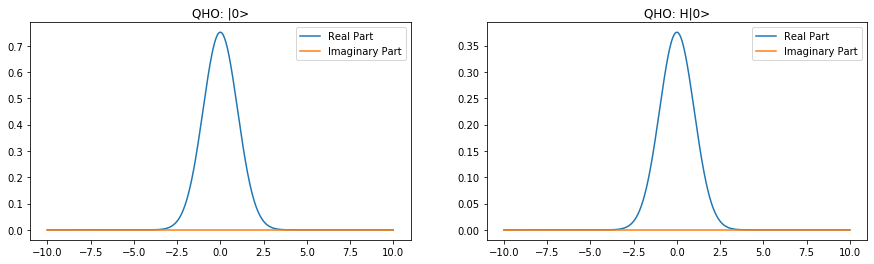

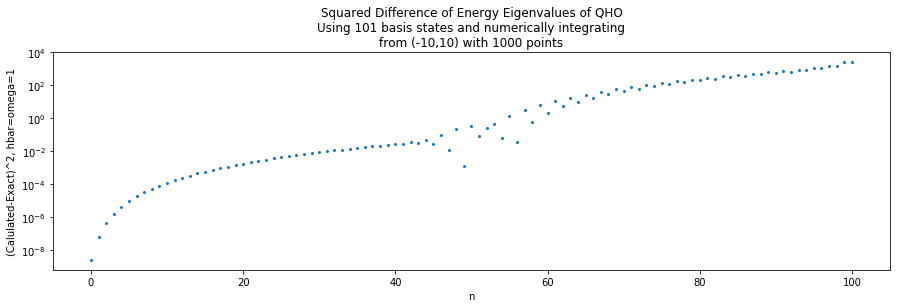

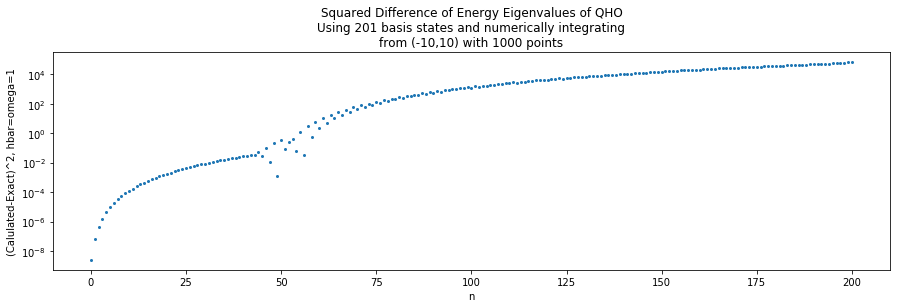

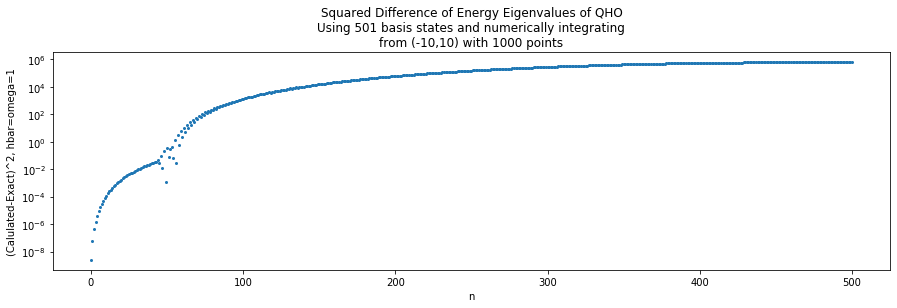

In [45]:
from time import time

m=1
omega=1
harmOscHamil = (1/2/m)*Operator.Momentum()**2 + (m*omega**2 /2)*Operator.Position()**2
harmOscHamil.verbose = True

HOGroundState = State( lambda x : np.exp(-x**2 *m*omega/2/Operator.hbar), np.linspace(-10,10,1000) ).norm()

t = time()
# print("Ground State Energy:", np.real(HOGroundState*( harmOscHamil*HOGroundState ) ))
plt.figure(1,figsize=(15,4))
plt.subplot(121)
plt.title('QHO: |0>')
( HOGroundState ).plot()
plt.subplot(122)
plt.title('QHO: H|0>')
( harmOscHamil*HOGroundState ).plot()
print('Time to plot Ground State:', time()-t)
print()

t=time()
plt.figure(2,figsize=(15,4))
N=50
num_x_points = 1000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(3,figsize=(15,4))
N=100
num_x_points = 1000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(4,figsize=(15,4))
N=250
num_x_points = 1000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

Above I studied how including more basis states (as the number in reality is infinite) affects the squared error from the exact result. You can see that simply adding more basis states to use for the calculation of eigenvalues does not change the error. I suspect that this error may simply be a numerical precision error - limited by the number of bits the computer can use to store numbers. Also, vectorizing calculation of the matrix via `numpy.outer` makes it much faster than brute forcing it (which is to be expected).

DEBUG: ('Making matrix: ', (101, 101))
DEBUG: ('Basis States Made',)
DEBUG: ('Matrix is ', (101, 101))
Time to calculate Energy Eigenvals with 101 basis states: 4.131668567657471

Time to calculate Energy Eigenvals with 101 basis states: 0.016994953155517578

Time to calculate Energy Eigenvals with 101 basis states: 0.017994165420532227



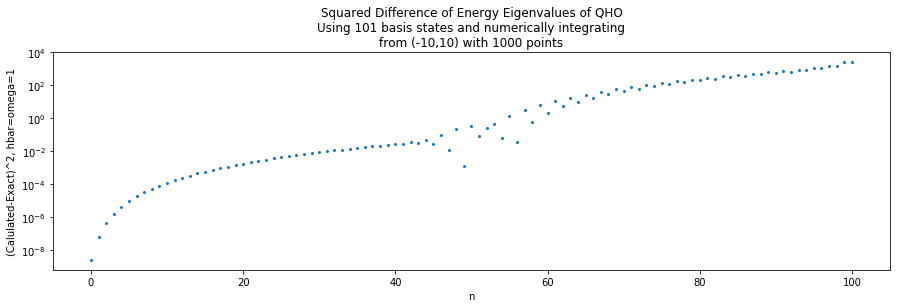

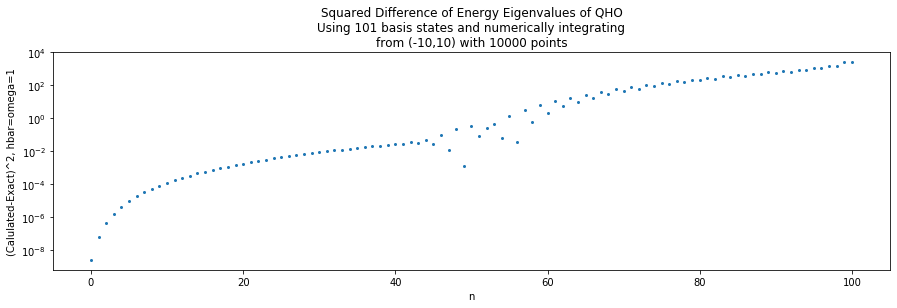

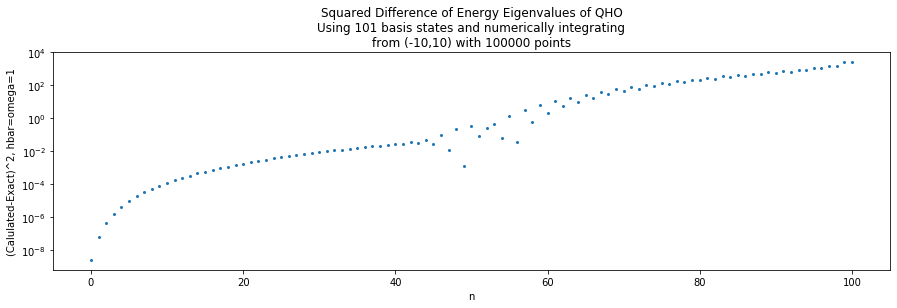

In [10]:
from time import time

m=1
omega=1
harmOscHamil = (1/2/m)*Operator.Momentum()**2 + (m*omega**2 /2)*Operator.Position()**2
harmOscHamil.verbose = True

t=time()
plt.figure(2,figsize=(15,4))
N=50
num_x_points = 1000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(3,figsize=(15,4))
N=50
num_x_points = 10000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(4,figsize=(15,4))
N=50
num_x_points = 100000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

DEBUG: ('Making matrix: ', (101, 101))
DEBUG: ('Basis States Made',)
DEBUG: ('Matrix is ', (101, 101))
Time to calculate Energy Eigenvals with 101 basis states: 4.3303492069244385

Time to calculate Energy Eigenvals with 101 basis states: 0.01604628562927246

Time to calculate Energy Eigenvals with 101 basis states: 0.015995025634765625



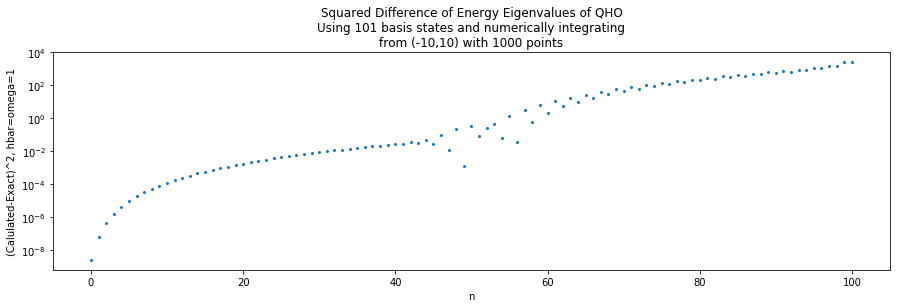

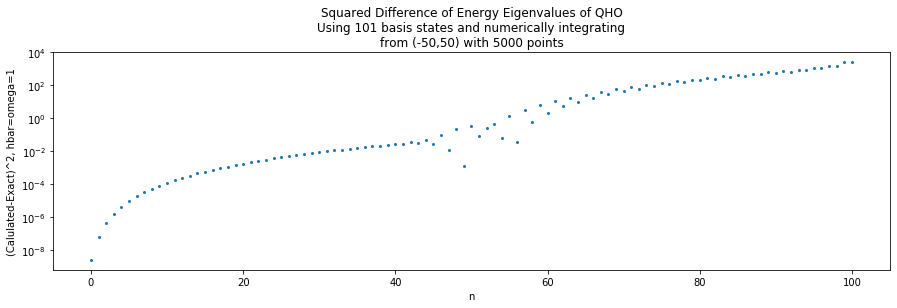

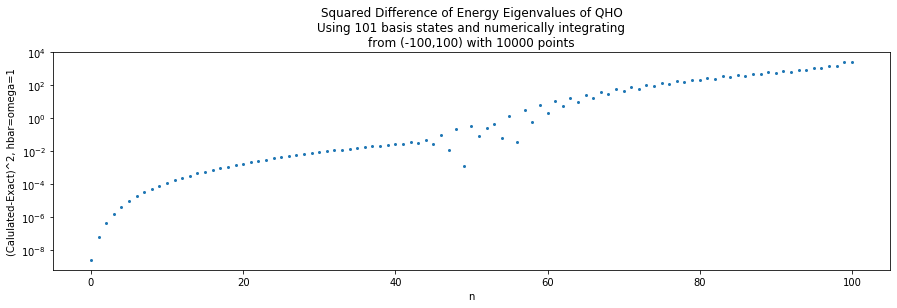

In [11]:
from time import time

m=1
omega=1
harmOscHamil = (1/2/m)*Operator.Momentum()**2 + (m*omega**2 /2)*Operator.Position()**2
harmOscHamil.verbose = True

t=time()
plt.figure(2,figsize=(15,4))
N=50
num_x_points = 1000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-10,10,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-10,10) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(3,figsize=(15,4))
N=50
num_x_points = 5000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-50,50,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-50,50) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

t=time()
plt.figure(4,figsize=(15,4))
N=50
num_x_points = 10000
calc_eigenvals = np.sort(np.real( harmOscHamil.find_eig( np.linspace(-100,100,num_x_points),N=N )[0] ))
exact_eigenvals = Operator.hbar*omega*( np.arange(0,2*N+1,1) + 0.5 )
plt.plot( (calc_eigenvals-exact_eigenvals)**2,'o',ms=2)
plt.title('Squared Difference of Energy Eigenvalues of QHO\nUsing ' + str(2*N+1) + ' basis states and numerically integrating\nfrom (-100,100) with '+str(num_x_points)+' points')
plt.ylabel( '(Calulated-Exact)^2, hbar=omega=1' )
plt.xlabel( 'n' )
plt.yscale( 'log' )
print('Time to calculate Energy Eigenvals with '+str(2*N+1)+' basis states:', time()-t)
print()

#### Conclusion about Eigenvalues
So changing the number of basis states, the number of points along the integration and the range of integration do not move or remove the "kink" in the graph of the error.

## Particle in a box

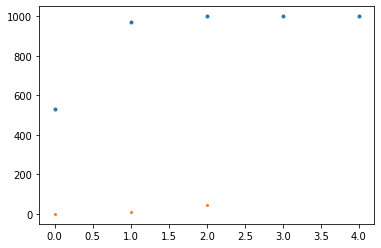

In [42]:
def potential(a_state):
    L = 1
    V0=1000
    V = V0*( np.array(a_state[0]>L/2,dtype=int)+np.array(a_state[0]<-L/2,dtype=int) )
    return State( lambda x : V*a_state.x_rep_func(x),a_state[1] )

# V = 
m=1
H = (1/2/m)*Operator.Momentum2() + Operator(potential)

N=2
num_x_points = 1000
L = 10
plt.plot( np.sort(np.real( H.find_eig( np.linspace(-L/2,L/2,num_x_points),N=N )[0] )),'o',ms=3 )
plt.plot( (np.linspace(0,3,3)*np.pi*Operator.hbar)**2 /2/m,'o',ms=2)

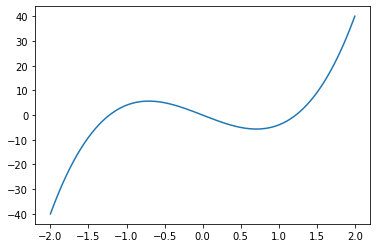

In [12]:
from numpy.polynomial.hermite import Hermite
x,y=Hermite([0,0,0,1]).linspace(1000,(-2,2))
plt.plot(x,y)